In [1]:
import numpy as np
import pandas as pd
import csv
import keras.backend as K
import matplotlib.pyplot as plt
import os
import fnmatch

from tqdm import tqdm

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from numba import cuda 
device = cuda.get_current_device()
device.reset()

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
# train_len = 25253
# validation_len = 9471
# test_len = 13794
# train_length = 2684
# val_length = 726
# test_length = 1498
train_length = 96
val_length = 30
test_length = 44

def load_features(filename,
                  skip_header=True,
                  skip_instname=True,
                  delim=' ',
                  num_lines=0):
    if num_lines == 0:
        num_lines = get_num_lines(filename, skip_header)

    data = np.empty(
        (num_lines, 50), float)

    with open(filename, 'r') as csv_file:
        if skip_header:
            next(csv_file)
        c = 0
        for line in tqdm(csv_file):
            offset = 0
            if skip_instname:
                offset = line.find(delim) + 1
            data[c, :] = np.fromstring(line[offset:], dtype=float, sep=delim)
            c += 1

    return data

def load_batch_features(filename, start_index=0, amount=0):
    delim = ' '
    
    data = np.empty((amount, 25), float)
    
    with open(filename, 'r') as csv_file:
        for i, line in tqdm(enumerate(csv_file)):
            if i < start_index:
                continue
            if i >= start_index + amount:
                break
            index = i - start_index
            data[index, :] = np.fromstring(line, dtype=float, sep=delim)
    return data
    
def load_batch_labels(filename, start_index=1, amount=0):
    labels = np.empty((amount, 3), float)
    delim = ','
    
    with open(filename, 'r') as csv_file:
        for i, line in tqdm(enumerate(csv_file)):
            if i < start_index:
                continue
            if i >= start_index + amount:
                break
            cols = np.fromstring(line, dtype=float, sep=delim)
            index = i - start_index
            labels[index, :] = cols[1:]
    return labels
    
def get_num_lines(filename, skip_header):
    with open(filename, 'r') as csv_file:
        if skip_header:
            next(csv_file)
        c = 0
        for line in csv_file:
            c += 1
    return c

def load_labels(filename,
                  skip_header=True,
                  skip_instname=True,
                  delim=' ',
                  num_lines=0):
    if num_lines == 0:
        num_lines = get_num_lines(filename, skip_header)

    data = np.empty(
        (num_lines, 3), float)

    with open(filename, 'r') as csv_file:
        if skip_header:
            next(csv_file)
        c = 0
        for line in tqdm(csv_file):
            offset = 0
            if skip_instname:
                offset = line.find(delim) + 1
            data[c, :] = np.fromstring(line[offset:], dtype=float, sep=delim)
            c += 1

    return data
    
    
def get_scaler(x):
    x_scaler = StandardScaler()
    x_scaler.fit(x)
  
    return x_scaler

def scale_data(scaler, data):
    if data.ndim > 2:
        data = data.reshape(-1, data.shape[2])
    scaled = scaler.transform(data)
    
    return scaled

def ccc(gold, pred):
    gold       = K.squeeze(gold, axis=-1)
    pred       = K.squeeze(pred, axis=-1)
    gold_mean  = K.mean(gold, axis=-1, keepdims=True)
    pred_mean  = K.mean(pred, axis=-1, keepdims=True)
    covariance = (gold-gold_mean)*(pred-pred_mean)
    gold_var   = K.mean(K.square(gold-gold_mean), axis=-1,  keepdims=True)
    pred_var   = K.mean(K.square(pred-pred_mean), axis=-1, keepdims=True)
    ccc        = K.constant(2.) * covariance / (gold_var + pred_var + K.square(gold_mean - pred_mean) + K.epsilon())
    return ccc

def ccc_loss(gold, pred):
    ccc_loss = K.constant(1.) - ccc(gold, pred)
    return ccc_loss


### Batch loading to train LSTM-RNN

- First, load all data to get scalers that covers for each partition data
- Batching the data to train
- Batching the data to validation

In [3]:
data_path = './LLDs_conversation/'
# data_path = './LLDs_podcast/'

seq_len = 847
# seq_len = 388
n_features = 25


# load all data to get a scaler that covers all data
print("Loading training samples...")
x_train = load_features(data_path+'train.txt', skip_header=False, skip_instname=False)
train_labels = load_labels(data_path+'train_labels_lag_compensated.txt', skip_header=False, skip_instname=False)
y_train = train_labels.reshape((train_length, seq_len, 3))

print("Loading finished, Scaling...")
x_scaler = get_scaler(x_train)

# Scaling acoustic features
x_train_scaled = scale_data(x_scaler, x_train)
# Scaling labels from [-100,100] to [-1, 1]
f = lambda x: x * 0.01
y_train_scaled = f(y_train)
x_train_scaled = x_train_scaled.reshape((train_length, seq_len, n_features * 2))
print('x_train shape:', x_train_scaled.shape)
print('y_train shape:', y_train_scaled.shape)
print("End of loading and preprocessing training samples")

print("Loading validation samples...")
x_validation = load_features(data_path+'validation.txt', skip_header = False, skip_instname=False)
val_labels = load_labels(data_path+'validation_labels_lag_compensated.txt', skip_header=False, skip_instname=False)
y_validation = val_labels.reshape((val_length, seq_len, 3))
print("Loading finished, Scaling...")
x_val_scaled = scale_data(x_scaler, x_validation)
y_val_scaled = f(y_validation)
x_val_scaled = x_val_scaled.reshape((val_length, seq_len, n_features * 2))

print('x_validation shape:', x_val_scaled.shape)
print('y_validation shape:', y_val_scaled.shape)
print("End of loading and preprocessing validation samples")

print("Loading testing samples...")
x_test = load_features(data_path+'test.txt', skip_header = False, skip_instname=False)
test_labels = load_labels(data_path+'test_labels_lag_compensated.txt', skip_header=False, skip_instname=False)
y_test = test_labels.reshape((test_length, seq_len, 3))
print("Loading finished, Scaling...")
x_test_scaled = scale_data(x_scaler, x_test)
y_test_scaled = f(y_test)
x_test_scaled = x_test_scaled.reshape((test_length, seq_len, n_features * 2))

print('x_test shape:', x_test_scaled.shape)
print('y_test shape:', y_test_scaled.shape)
print("End of loading and preprocessing test samples")

Loading training samples...


81312it [00:01, 51806.28it/s]
81312it [00:00, 225456.42it/s]


Loading finished, Scaling...
x_train shape: (96, 847, 50)
y_train shape: (96, 847, 3)
End of loading and preprocessing training samples
Loading validation samples...


25410it [00:00, 48668.91it/s]
25410it [00:00, 187867.23it/s]


Loading finished, Scaling...
x_validation shape: (30, 847, 50)
y_validation shape: (30, 847, 3)
End of loading and preprocessing validation samples
Loading testing samples...


37268it [00:00, 48071.44it/s]
37268it [00:00, 178731.83it/s]

Loading finished, Scaling...
x_test shape: (44, 847, 50)
y_test shape: (44, 847, 3)
End of loading and preprocessing test samples


In [4]:
# headers = y_train.columns
# print(headers)
headers = ['Arousal', 'Valence', 'Dominance']

In [5]:
len(y_train_scaled)

96

### Building RNN-LSTM model


In [6]:
import keras.backend as K
from keras.models import Model, save_model, load_model, Sequential
from keras.layers import Input, Dense, Masking, LSTM, Dropout, TimeDistributed, Bidirectional, Flatten, Embedding, Conv1D, BatchNormalization, MaxPool1D
from tensorflow.keras.optimizers import RMSprop, Adam, SGD

from numpy.random import seed
from tensorflow.keras.utils import set_random_seed
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

### Multi-task learning

three models are integrated and each model covers Arousal, Valence, Dominance respectively.

In [8]:
# train_length = 25253
# val_length = 9471
# test_length = 13794
# train_length = 41815
# val_length = 13451
# test_length = 22633

n_features = 50
random_seed = 42

epochs = 50
batch_size = 1


def create_model(n_units1=64, n_units2=32):
    model = Sequential()
    inputs = Input(shape=(seq_len, n_features), dtype=float)
    mask = Masking()(inputs)
    lstm_1 = LSTM(n_units1, return_sequences=True)(mask)
    lstm_2 = LSTM(n_units2, return_sequences=True)(lstm_1)
    lstm_2 = Dropout(0.3)(lstm_2)
    modes = lstm_2
    output = [TimeDistributed(Dense(1), name=name)(modes) for i, name in enumerate(headers)]
    
    model = Model(inputs=inputs, outputs=output)
    
    rmsprop = RMSprop(lr=0.0001)
    model.compile(optimizer=rmsprop, loss=ccc_loss, metrics=[ccc])
    return model    

In [9]:
model = create_model(n_units1=256, n_units2=256)
# tf.keras.utils.plot_model(model, show_shapes=True)

2022-07-31 15:57:25.007188: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-31 15:57:25.081310: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-31 15:57:25.081657: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-31 15:57:25.083095: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [9]:
def transform_mtl(y):
    y_dta = []
    index = [0,1,2]
    for i in index:
        dim = np.empty((len(y), seq_len, 1))
        dim[:,:,0] = y[:,:,i]
        y_dta.append(dim)
    return y_dta

y_train_dta = transform_mtl(y_train_scaled)
y_val_dta = transform_mtl(y_val_scaled)
y_test_dta = transform_mtl(y_test_scaled)

callback = EarlyStopping(monitor='val_loss', patience=5, mode='min')


In [10]:
history = model.fit(x_train_scaled, y_train_dta, 
                    epochs=epochs, 
                    batch_size=batch_size,                     
                    validation_data=(x_val_scaled, y_val_dta), 
                    callbacks=[callback])
# plot_learningCurve(history, epochs)

Epoch 1/50


KeyboardInterrupt: 

In [10]:
x_combined = np.concatenate([x_train_scaled, x_val_scaled])
y_combined = []
for i in range(3):
    temp = np.concatenate([y_train_dta[i], y_val_dta[i]])
    y_combined.append(temp)
print("Combined features shape %s" % (str(x_combined.shape)))
print("Combined labels shape and target num %s and %s" % (str(y_combined[0].shape), str(len(y_combined))))

Combined features shape (126, 847, 50)
Combined labels shape and target num (126, 847, 1) and 3


In [ ]:
model = create_model(n_units1=256, n_units2=256)

history = model.fit(x_combined, y_combined, 
                    epochs=epochs, 
                    batch_size=batch_size,                     
                    validation_data=(x_test_scaled, y_test_dta), 
                    callbacks=[callback])

### Linguistic model

In [11]:
import nltk
import ssl
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/changhyun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
def clean_text(text):
    
    punctuation = [i for i in ',./\\;:\'@#~[{]}=+-_)(*&^%$£"!`)]']
    STOPWORDS = set(stopwords.words('english'))
    
    text = text.replace("'s", "")
    text = "".join([" " if t in punctuation else t for t in text]).lower()
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwords from text
    return text

In [15]:
import json

segment_path = os.path.relpath('./MSP Data/Time Labels/segments.json')
f = open(segment_path, 'r')
timing_data = json.load(f)

# transcripts_path = './LLDs_podcast/transcripts/'
transcripts_path = './LLDs_conversation/transcripts/'
lld_path = './LLDs_conversation/'
sections = ['train/', 'validation/', 'test/']

min_time = 1.0

train = []
val = []
test = []
for i, section in enumerate(sections):
    files = fnmatch.filter(os.listdir(lld_path + section), '*.csv')
    insts = [file.split('.')[0] for file in files]
    if i == 0:
        train = insts
    elif i == 1:
        val = insts
    else:
        test = insts

transcripts = fnmatch.filter(os.listdir(transcripts_path), '*.txt')
transcripts.sort()
train_files = []
val_files = []
test_files = []

train_text = []
val_text = []
test_text = []
for transcript in transcripts:
    
    with open(transcripts_path + transcript) as f:
        lines = f.readlines()
    inst = transcript.split('.')[0]
    if inst in train:
        train_files.append(inst)
        train_text.append(lines[0])
    elif inst in val:
        val_files.append(inst)
        val_text.append(lines[0])
    else:
        test_files.append(inst)
        test_text.append(lines[0])
df_train = pd.DataFrame({'Filename': train_files, 'txt': train_text})
df_val = pd.DataFrame({'Filename': val_files, 'txt': val_text})
df_test = pd.DataFrame({'Filename': test_files, 'txt': test_text})
# MSP-PODCAST code
# for i, section in enumerate(sections):
#     files = fnmatch.filter(os.listdir(transcripts_path+section), '*.txt')
#     files.sort()
#     text = []
#     filename = []
#     for file in files:
#         inst = file.split('.')[0]
        
#         if 'MSP-PODCAST_0153' in inst or 'MSP-PODCAST_1188_0020' in inst:
#             continue
#         start = timing_data[inst]['Start_Time']
#         end = timing_data[inst]['End_Time']
#         if end - start < min_time:
#             continue
#         filename.append(inst)        
#         with open(transcripts_path+section+file) as f:
#             lines = f.readlines()
#         if len(lines) == 0:
#             text.append('')
#         else:
#             text.append(lines[0])
#     if i == 0:
#         df_train = pd.DataFrame({'Filename': filename, 'txt':text})
        
#     elif i == 1:
#         df_val = pd.DataFrame({'Filename': filename, 'txt':text})
        
#     else:
#         df_test = pd.DataFrame({'Filename': filename, 'txt':text})
         

In [16]:
df_train.iloc[0, 1]

"Convergence one solution, one service provider, Tommy must be transmitted. Even tell me was why, who was the day edited the sweater new started, this with, and business section. How long ago was that? I ate twice a year after I return from my. How about I seen that? It was a 85. 4K section. Is, Korea revolves. You do now own mafube are publishing publishing iskcon, South existed? But there's a lot of business, you know, I'm in the area and you could to pay your fees, you know, and so on. When that the lessons I lent there a video available for the for my new a small business that I've just started. I mean, it's now a year. After day since I retired from the University. So what I lent it to my food is going to stand me in good stead of the School of Hard Knocks and then just have to Hanna's Bakery and head this way to campus. I mean, they are these are some of the issues that they were used to wear a dress. What are the elements of a successful businesses? How do you see signs that you

In [17]:
train_cleaned = df_train['txt'].apply(clean_text)
val_cleaned = df_val['txt'].apply(clean_text)
test_cleaned = df_test['txt'].apply(clean_text)
combined_cleaned = pd.concat([train_cleaned, val_cleaned, test_cleaned], ignore_index=True)

print("Cleaned train text: %d" % (len(train_cleaned)))
print("Cleaned validation text: %d" % (len(val_cleaned)))
print("Cleaned test text: %d" % (len(test_cleaned)))
print("Cleaned all text: %d" % (len(combined_cleaned)))

Cleaned train text: 96
Cleaned validation text: 30
Cleaned test text: 44
Cleaned all text: 170


In [18]:
vocab = set()

for i in range(len(combined_cleaned)):
    text = combined_cleaned[i]
    tokens = text.split()
    for token in tokens:
        vocab.add(token)
vocab_size = len(vocab)
vocab_size

9582

In [19]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

sentence_len = [len(sent.split()) for sent in combined_cleaned.tolist()]
sent_len = max(sentence_len)
print('Max sentence length: %d' % (sent_len))
text_vec = TextVectorization(max_tokens=vocab_size, 
                             pad_to_max_tokens=True, 
                             output_sequence_length=seq_len,
                             output_mode='int')
text_vec.adapt(train_cleaned)

Max sentence length: 915


2022-08-01 16:00:06.495991: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-01 16:00:06.536842: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-01 16:00:06.538030: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-01 16:00:06.539172: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [37]:
ling_model = Sequential()
ling_model.add(Input(shape=(1,), dtype=tf.string))
ling_model.add(text_vec)

ling_model.predict([train_cleaned[100]])

1/1 [==============================] - 0s 122ms/step


array([[ 238, 1273,  285, 4693,  238,  267, 4943,  322, 1162, 1217,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0, 

In [20]:
from numpy import array

# loading pre-trained weights and build embedding layer
embeddings_index = dict()
embedding_dim = 300
f = open('embeddings/glove.6B.300d.txt')
for line in f:
	values = line.split()
	word = values[0]
	coefs = np.asarray(values[1:], dtype='float32')
	embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400001 word vectors.


In [21]:
embedding_matrix = np.zeros((vocab_size+ 1, embedding_dim))
for i, word in enumerate(text_vec.get_vocabulary()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [22]:
embedding_layer = Embedding(vocab_size + 1, 
                            embedding_dim,
                            weights=[embedding_matrix],
                            input_length=seq_len,
                            trainable=True,
                            name='GloVe')

In [23]:
from keras.layers import Concatenate, Layer, GlobalMaxPooling1D, concatenate, dot, multiply, Activation
from keras.layers.core import Lambda

def create_bimodal_model(n_units1=64, n_units2=32):
    ling_model = Sequential()
    ling_inputs = Input(shape=(1,), dtype=tf.string)
    vec = text_vec(ling_inputs)
    embed = Embedding(vocab_size + 1, 
                            embedding_dim,                            
                            input_length=seq_len,
                            trainable=True,
                            name='Embedding')(vec)
#     embed = embedding_layer(vec)
    lstm1 = LSTM(n_units1, return_sequences=True)(embed)
    lstm2 = LSTM(n_units2, return_sequences=True, dropout=0.3)(lstm1)
    lstm2 = LSTM(n_units2, return_sequences=True, dropout=0.3)(lstm2)
    lstm2 = Dropout(0.2)(lstm2)
    ling_output = [TimeDistributed(Dense(1), name='ling_'+name)(lstm2) for i, name in enumerate(headers)]
    ling_model = Model(inputs=ling_inputs, outputs=ling_output)
    
    acoustic_model = Sequential()
    inputs = Input(shape=(seq_len, n_features), dtype=float)
    mask = Masking()(inputs)
    lstm_1 = LSTM(n_units1, return_sequences=True)(mask)
    lstm_2 = LSTM(n_units2, return_sequences=True, dropout=0.3)(lstm_1)
    lstm_2 = LSTM(n_units2, return_sequences=True, dropout=0.3)(lstm_2)
    lstm_2 = Dropout(0.2)(lstm_2)
    acous_output = [TimeDistributed(Dense(1), name='acoustic_'+name)(lstm_2) for i, name in enumerate(headers)]
    
    acoustic_model = Model(inputs=inputs, outputs=acous_output)
    late_fusion = []
    for output in ling_model.output:
        late_fusion.append(output)
    for output in acoustic_model.output:
        late_fusion.append(output)
    concat = Concatenate()(late_fusion)
    lstm_last = LSTM(128, return_sequences=True)(concat)
#     dense_last = TimeDistributed(Dense(32))(concat)
    output = [TimeDistributed(Dense(1), name=name)(lstm_last) for i, name in enumerate(headers)]
    
    bimodal_model = Model(inputs=[ling_inputs, inputs], outputs=output)
    
    rmsprop = RMSprop(lr=0.0001)
    bimodal_model.compile(optimizer=rmsprop, loss=ccc_loss, metrics=[ccc])
    return bimodal_model

def create_late_fusion_cnn_model(n_units=256, optimizer='rmsprop', activation='relu', use_glove=True):
    ling_model = Sequential()
    ling_inputs = Input(shape=(1,), dtype=tf.string)
    vec = text_vec(ling_inputs)
    if use_glove:
        embed = embedding_layer(vec)
    else:
        embed = Embedding(vocab_size + 1, 
                                embedding_dim,                            
                                input_length=seq_len,
                                trainable=True,
                                name='Embedding')(vec)

    net_speech = Conv1D(n_units, 3, padding='same', activation=activation)(embed)
    net_speech = BatchNormalization()(net_speech)
    net_speech = Conv1D(n_units, 5, padding='same', activation=activation)(net_speech)
    net_speech = BatchNormalization()(net_speech)
    net_speech = Conv1D(n_units, 10, padding='same', activation=activation)(net_speech)
    net_speech = BatchNormalization()(net_speech)
    
    net_speech = Dropout(0.3)(net_speech)
    ling_output = [TimeDistributed(Dense(1), name='ling_'+name)(net_speech) for i, name in enumerate(headers)]
    ling_model = Model(inputs=ling_inputs, outputs=ling_output)
    
    acoustic_model = Sequential()
    inputs = Input(shape=(seq_len, n_features), dtype=float)
    mask = Masking()(inputs)
    
    net_acoustic = Conv1D(n_units, 3, padding='same', activation=activation)(mask)
    net_acoustic = BatchNormalization()(net_acoustic)
    net_acoustic = Conv1D(n_units, 5, padding='same', activation=activation)(net_acoustic)
    net_acoustic = BatchNormalization()(net_acoustic)
    net_acoustic = Conv1D(n_units, 10, padding='same', activation=activation)(net_acoustic)
    net_acoustic = BatchNormalization()(net_acoustic)
    
    acous_output = [TimeDistributed(Dense(1), name='acoustic_'+name)(net_acoustic) for i, name in enumerate(headers)]
    
    acoustic_model = Model(inputs=inputs, outputs=acous_output)
    late_fusion = []
    for output in ling_model.output:
        late_fusion.append(output)
    for output in acoustic_model.output:
        late_fusion.append(output)
    concat = Concatenate()(late_fusion)
    lstm_last = LSTM(n_units, return_sequences=True)(concat)
#     dense_last = TimeDistributed(Dense(32))(concat)
    output = [TimeDistributed(Dense(1), name=name)(lstm_last) for i, name in enumerate(headers)]
    
    bimodal_model = Model(inputs=[ling_inputs, inputs], outputs=output)
    
    if optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=0.0001)
    elif optimizer == 'Adam':
        opt = Adam(learning_rate=0.0001)
    else:
        opt = SGD(learning_rate=0.0001)
    
    bimodal_model.compile(optimizer=opt, loss=ccc_loss, metrics=[ccc])
    return bimodal_model


def bi_modal_attention(x, y):
    
    ''' 
    .  stands for dot product 
    *  stands for elemwise multiplication
    {} stands for concatenation
        
    m1 = x . transpose(y) ||  m2 = y . transpose(x) 
    n1 = softmax(m1)      ||  n2 = softmax(m2)
    o1 = n1 . y           ||  o2 = m2 . x
    a1 = o1 * x           ||  a2 = o2 * y
       
    return {a1, a2}
        
    '''
     
    m1 = dot([x, y], axes=[2, 2])
    n1 = Activation('softmax')(m1)
    o1 = dot([n1, y], axes=[2, 1])
    a1 = multiply([o1, x])

    m2 = dot([y, x], axes=[2, 2])
    n2 = Activation('softmax')(m2)
    o2 = dot([n2, x], axes=[2, 1])
    a2 = multiply([o2, y])

    return concatenate([a1, a2])

def attention_layer(n_units=256, optimizer='rmsprop', use_glove=True):
    a_input = Input(shape=(seq_len, n_features), name='acoustic_input')
    t_input = Input(shape=(1,), dtype=tf.string)
    vec = text_vec(t_input)
    if use_glove:
        embed = embedding_layer(vec)
    else:
        embed = Embedding(vocab_size + 1, 
                                embedding_dim,                            
                                input_length=seq_len,
                                trainable=True,
                                name='Embedding')(vec)
    
    a_masking = Masking(name='a_masking')(a_input)
    
    t_lstm = LSTM(n_units, return_sequences=True)(embed)
    t_lstm = Bidirectional(LSTM(n_units, return_sequences=True))(t_lstm)
    t_lstm = Dropout(0.3)(t_lstm)
    a_lstm = LSTM(n_units, return_sequences=True)(a_masking)
    a_lstm = Bidirectional(LSTM(n_units, return_sequences=True))(a_lstm)
    a_lstm = Dropout(0.3)(a_lstm)
    
    t_dense = TimeDistributed(Dense(100))(t_lstm)
    a_dense = TimeDistributed(Dense(100))(a_lstm)
    
    att = bi_modal_attention(t_dense, a_dense)
    merged = Concatenate()([att, t_dense, a_dense])
    output = [TimeDistributed(Dense(1), name=name)(merged) for i, name in enumerate(headers)]
    model = Model([t_input, a_input], output)
    
    if optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=0.0001)
    elif optimizer == 'Adam':
        opt = Adam(learning_rate=0.0001)
    else:
        opt = SGD(learning_rate=0.0001)
        
    model.compile(optimizer=opt, loss=ccc_loss, metrics=[ccc])
    
    return model


def hfusion(n_units=256, optimizer='rmsprop', use_glove=True):
    
    acoustic_input = Input(shape=(seq_len, n_features), name='acoustic_input')
    masking = Masking(name='acoustic_mask')(acoustic_input)
    
    linguistic_input = Input(shape=(1,), dtype=tf.string)
    vec = text_vec(linguistic_input)
    if use_glove:
        embed = embedding_layer(vec)
    else:
        embed = Embedding(vocab_size + 1, 
                                embedding_dim,                            
                                input_length=seq_len,
                                trainable=True,
                                name='Embedding')(vec)

    linguistic_lstm = LSTM(n_units, return_sequences=True, name='linguistic_lstm1')(embed)
    linguistic_lstm = LSTM(n_units, return_sequences=True, name='linguistic_lstm2')(linguistic_lstm)
    linguistic_lstm = LSTM(n_units, return_sequences=True, name='linguistic_lstm3')(linguistic_lstm)
    
    concat = Concatenate()([masking, linguistic_lstm])
    
    bi_lstm = LSTM(n_units, return_sequences=True, dropout=0.3, name='bi_lstm1')(concat)
    bi_lstm = LSTM(n_units, return_sequences=True, dropout=0.3, name='bi_lstm2')(bi_lstm)
    bi_lstm = LSTM(n_units, return_sequences=True, dropout=0.3, name='bi_lstm3')(bi_lstm)
#     dense = TimeDistributed(Dense(64, name='Dense1'))(bi_lstm)
#     dense = TimeDistributed(Dense(32, name='Dense2'))(dense)
    output = [TimeDistributed(Dense(1), name=name)(bi_lstm) for i, name in enumerate(headers)]
    bimodal = Model([linguistic_input, acoustic_input], output)
    
    if optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=0.0001)
    elif optimizer == 'Adam':
        opt = Adam(learning_rate=0.0001)
    else:
        opt = SGD(learning_rate=0.0001)

    bimodal.compile(optimizer=opt, loss=ccc_loss, metrics=[ccc])
    return bimodal

def create_cnn_hfusion(n_units=256, optimizer='rmsprop', activation='relu', use_glove=True):
    acoustic_input = Input(shape=(seq_len, n_features), name='acoustic_input')
    masking = Masking(name='acoustic_mask')(acoustic_input)
    
    linguistic_input = Input(shape=(1,), dtype=tf.string)
    vec = text_vec(linguistic_input)
    if use_glove:
        embed = embedding_layer(vec)
    else:
        embed = Embedding(vocab_size + 1, 
                                embedding_dim,                            
                                input_length=seq_len,
                                trainable=True,
                                name='Embedding')(vec)
    
    net_speech = Conv1D(n_units, 3, padding='same', activation=activation)(embed)
    net_speech = BatchNormalization()(net_speech)
    net_speech = Conv1D(n_units, 5, padding='same', activation=activation)(net_speech)
    net_speech = BatchNormalization()(net_speech)
    net_speech = Conv1D(n_units, 10, padding='same', activation=activation)(net_speech)
    net_speech = BatchNormalization()(net_speech)
    
    concat = Concatenate()([masking, net_speech])
    
    bi_lstm = LSTM(n_units, return_sequences=True, dropout=0.3, name='bi_lstm1')(concat)
    bi_lstm = LSTM(n_units, return_sequences=True, dropout=0.3, name='bi_lstm2')(bi_lstm)
    bi_lstm = LSTM(n_units, return_sequences=True, dropout=0.3, name='bi_lstm3')(bi_lstm)
    
    output = [TimeDistributed(Dense(1), name=name)(bi_lstm) for i, name in enumerate(headers)]
    hfusion = Model([linguistic_input, acoustic_input], output)
    
    if optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=0.0001)
    elif optimizer == 'Adam':
        opt = Adam(learning_rate=0.0001)
    else:
        opt = SGD(learning_rate=0.0001)
        
    hfusion.compile(optimizer=opt, loss=ccc_loss, metrics=[ccc])
    return hfusion
    

In [25]:
hmodel = hfusion(n_units=512, use_glove=True, optimizer='rmsprop')
# attention = attention_layer()
# cnn_hmodel = create_bimodal_model(n_units1=512, n_units2=512)

train_val = pd.concat([train_cleaned, val_cleaned], ignore_index=True)

history = hmodel.fit([train_val, x_combined], y_combined, 
                    epochs=epochs, 
                    batch_size=batch_size,                     
                    validation_data=([test_cleaned, x_test_scaled], y_test_dta), 
                    callbacks=[callback])

Epoch 1/50


2022-08-01 16:01:37.591296: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
2022-08-01 16:01:37.830301: W tensorflow/core/common_runtime/forward_type_inference.cc:231] Type inference failed. This indicates an invalid graph that escaped type checking. Error message: INVALID_ARGUMENT: expected compatible input types, but input 1:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_LEGACY_VARIANT
    }
  }
}
 is neither a subtype nor a supertype of the combined inputs preceding it:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_FLOAT
    }
  }
}

	while inferring type of node 'cond_19/output/_18'


126/126 [==============================] - 52s 308ms/step - loss: 1.8891 - Arousal_loss: 0.4940 - Valence_loss: 0.9660 - Dominance_loss: 0.4291 - Arousal_ccc: 0.5060 - Valence_ccc: 0.0340 - Dominance_ccc: 0.5709 - val_loss: 1.6186 - val_Arousal_loss: 0.3380 - val_Valence_loss: 0.9286 - val_Dominance_loss: 0.3520 - val_Arousal_ccc: 0.6620 - val_Valence_ccc: 0.0714 - val_Dominance_ccc: 0.6480
Epoch 2/50
126/126 [==============================] - 36s 287ms/step - loss: 1.4155 - Arousal_loss: 0.3384 - Valence_loss: 0.7722 - Dominance_loss: 0.3049 - Arousal_ccc: 0.6616 - Valence_ccc: 0.2278 - Dominance_ccc: 0.6951 - val_loss: 1.1971 - val_Arousal_loss: 0.2781 - val_Valence_loss: 0.6790 - val_Dominance_loss: 0.2399 - val_Arousal_ccc: 0.7219 - val_Valence_ccc: 0.3210 - val_Dominance_ccc: 0.7601
Epoch 3/50
126/126 [==============================] - 35s 277ms/step - loss: 1.3080 - Arousal_loss: 0.3078 - Valence_loss: 0.7302 - Dominance_loss: 0.2701 - Arousal_ccc: 0.6922 - Valence_ccc: 0.2698 - 

KeyboardInterrupt: 

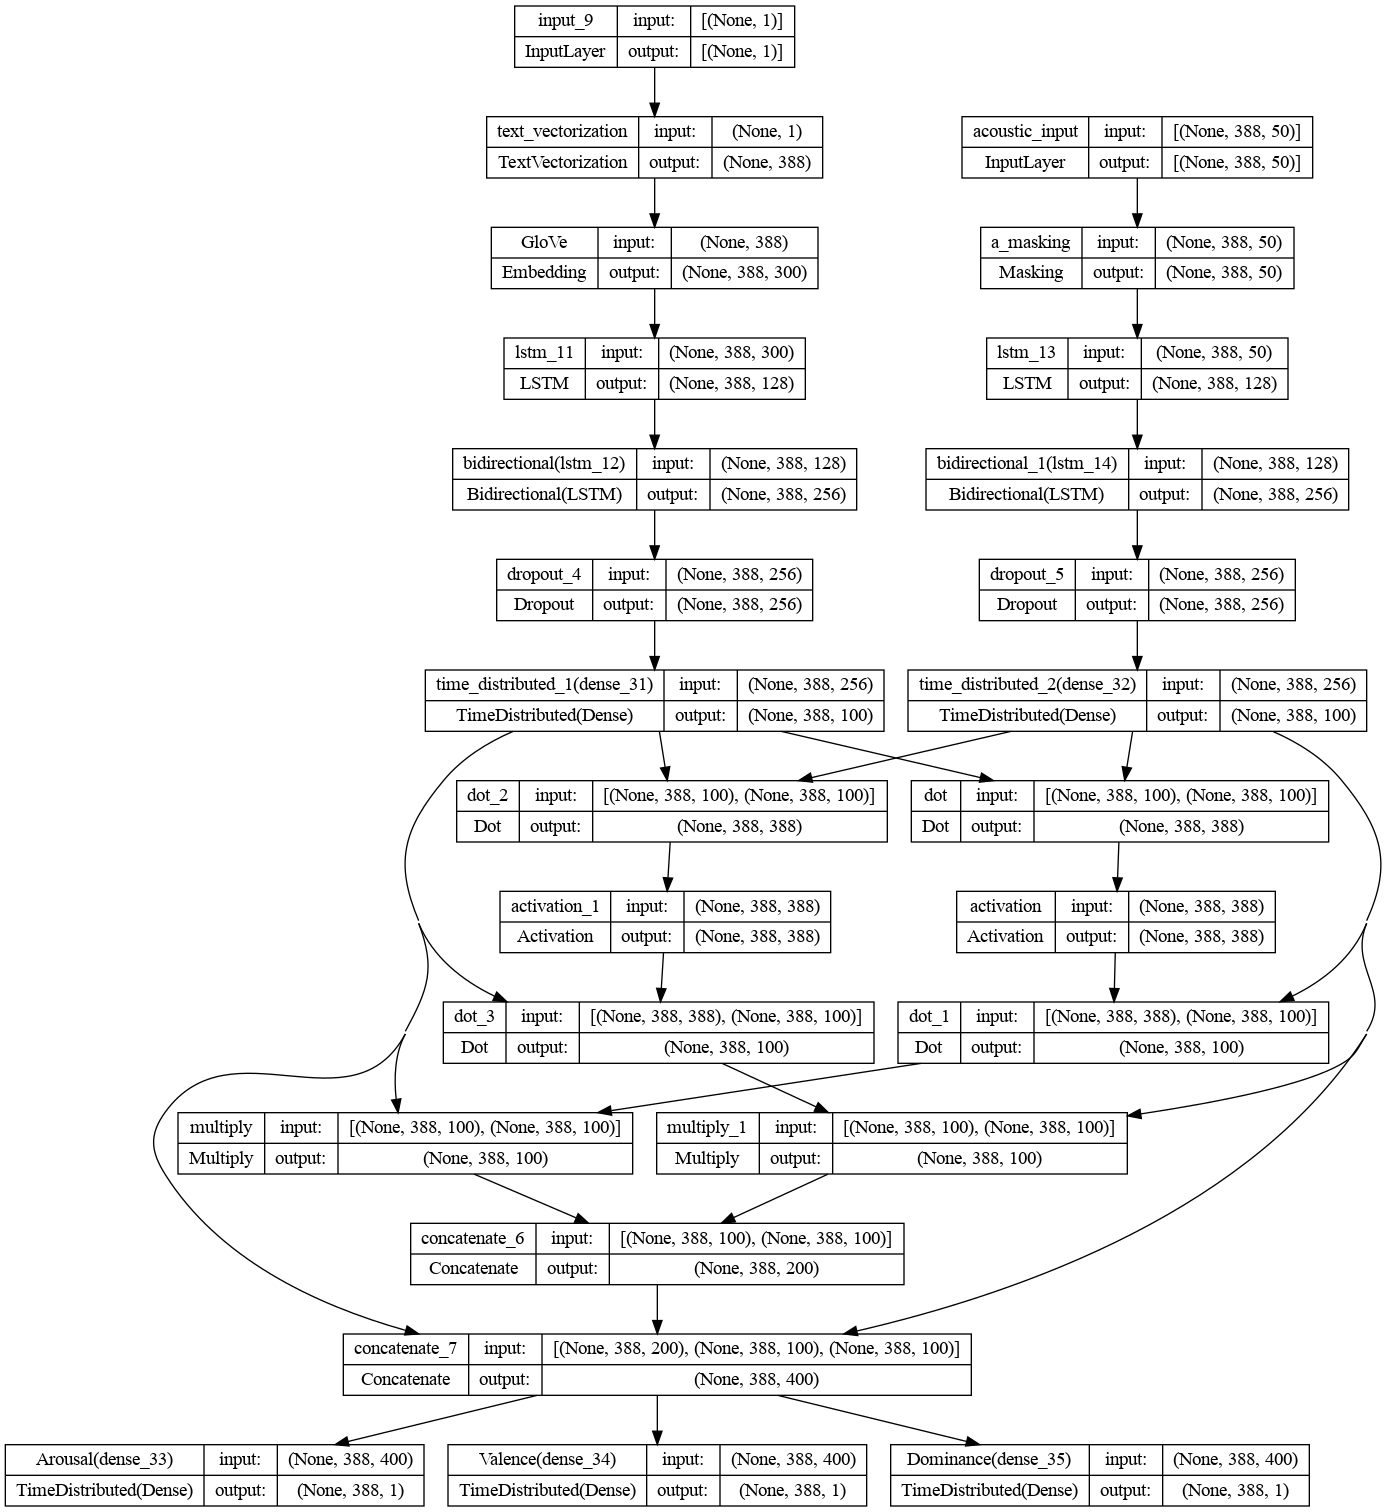

In [37]:
tf.keras.utils.plot_model(attention, show_shapes=True)

In [37]:
bimodal = create_bimodal_model(n_units1=512, n_units2=512)
# print(bimodal.summary())

train_val = pd.concat([train_cleaned, val_cleaned], ignore_index=True)

history = bimodal.fit([train_val, x_combined], y_combined, 
                    epochs=epochs, 
                    batch_size=batch_size,                     
                    validation_data=([test_cleaned, x_test_scaled], y_test_dta), 
                    callbacks=[callback])

Epoch 1/50
54/54 [==============================] - 55s 649ms/step - loss: 1.7692 - Arousal_loss: 0.4339 - Valence_loss: 0.8635 - Dominance_loss: 0.4717 - Arousal_ccc: 0.5661 - Valence_ccc: 0.1365 - Dominance_ccc: 0.5283 - val_loss: 1.2539 - val_Arousal_loss: 0.2989 - val_Valence_loss: 0.6769 - val_Dominance_loss: 0.2781 - val_Arousal_ccc: 0.7011 - val_Valence_ccc: 0.3231 - val_Dominance_ccc: 0.7219
Epoch 2/50
54/54 [==============================] - 29s 538ms/step - loss: 1.2240 - Arousal_loss: 0.2415 - Valence_loss: 0.7808 - Dominance_loss: 0.2016 - Arousal_ccc: 0.7585 - Valence_ccc: 0.2192 - Dominance_ccc: 0.7984 - val_loss: 0.9359 - val_Arousal_loss: 0.1474 - val_Valence_loss: 0.6773 - val_Dominance_loss: 0.1112 - val_Arousal_ccc: 0.8526 - val_Valence_ccc: 0.3227 - val_Dominance_ccc: 0.8888
Epoch 3/50
54/54 [==============================] - 29s 540ms/step - loss: 1.0710 - Arousal_loss: 0.1879 - Valence_loss: 0.7488 - Dominance_loss: 0.1343 - Arousal_ccc: 0.8121 - Valence_ccc: 0.25

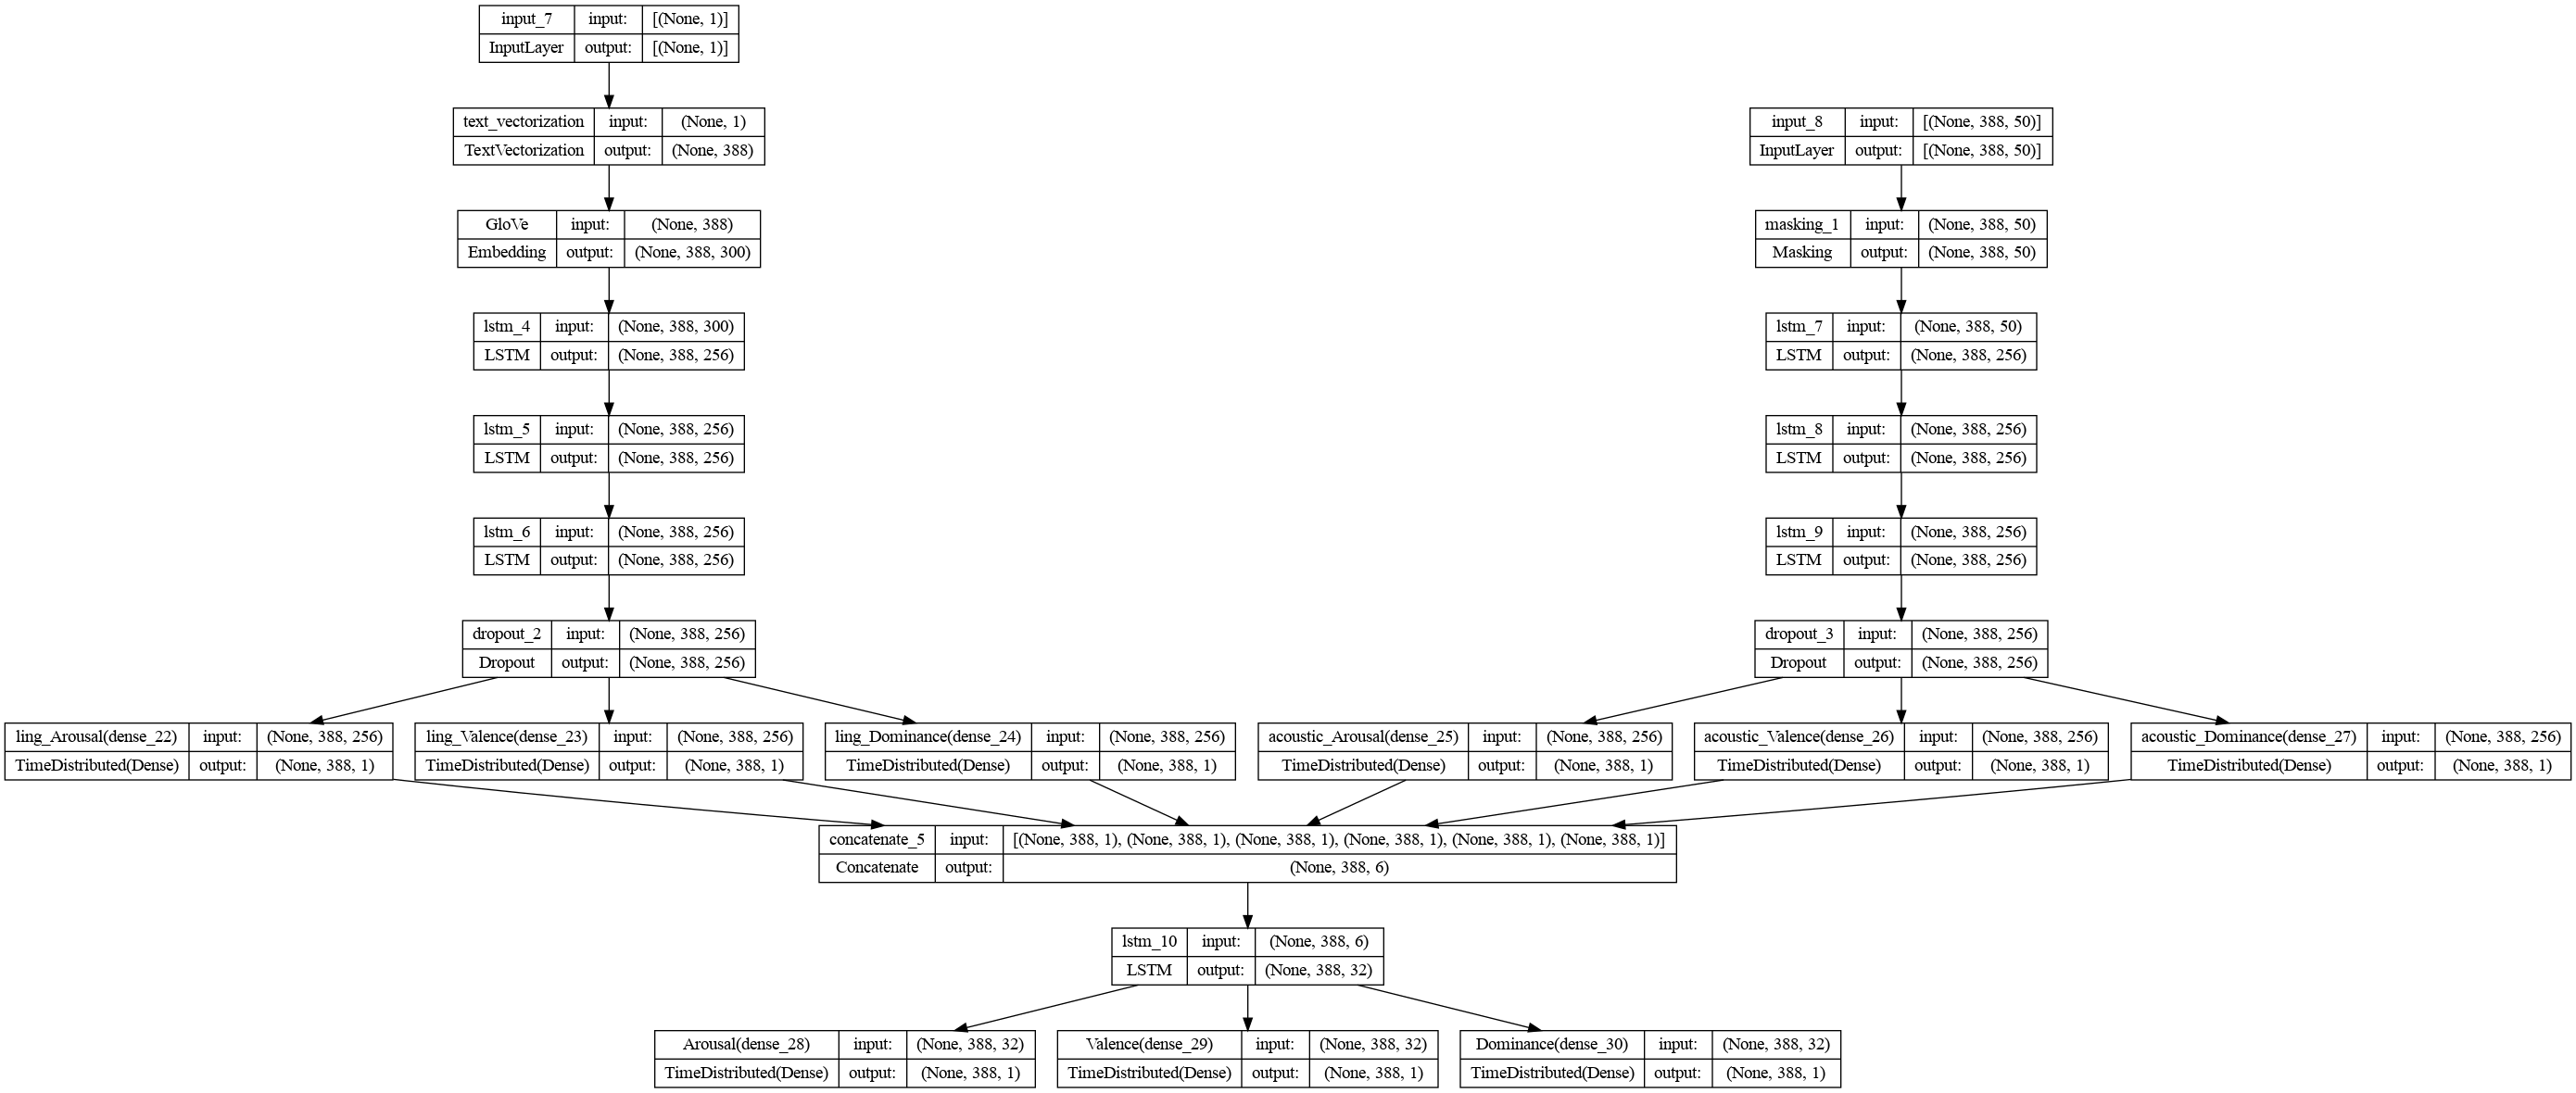

In [34]:
tf.keras.utils.plot_model(bimodal, show_shapes=True)

In [49]:
ling = create_linguistic(n_units1=256, n_units2=256)
callback = EarlyStopping(monitor='val_loss', patience=5, mode='min')

history = bimodal.fit([train_val, x_combined], y_combined, 
                    epochs=epochs, 
                    batch_size=batch_size,                     
                    validation_data=([test_cleaned, x_test_scaled], y_test_dta), 
                    callbacks=[callback])

Epoch 1/50
126/126 [==============================] - 34s 182ms/step - loss: 1.4452 - Arousal_loss: 0.3766 - Valence_loss: 0.7350 - Dominance_loss: 0.3337 - Arousal_ccc: 0.6234 - Valence_ccc: 0.2650 - Dominance_ccc: 0.6663 - val_loss: 1.1244 - val_Arousal_loss: 0.2976 - val_Valence_loss: 0.6347 - val_Dominance_loss: 0.1920 - val_Arousal_ccc: 0.7024 - val_Valence_ccc: 0.3653 - val_Dominance_ccc: 0.8080
Epoch 2/50
126/126 [==============================] - 19s 153ms/step - loss: 1.2371 - Arousal_loss: 0.2886 - Valence_loss: 0.6970 - Dominance_loss: 0.2515 - Arousal_ccc: 0.7114 - Valence_ccc: 0.3030 - Dominance_ccc: 0.7485 - val_loss: 1.1307 - val_Arousal_loss: 0.2977 - val_Valence_loss: 0.6331 - val_Dominance_loss: 0.2000 - val_Arousal_ccc: 0.7023 - val_Valence_ccc: 0.3669 - val_Dominance_ccc: 0.8000
Epoch 3/50
126/126 [==============================] - 19s 152ms/step - loss: 1.2096 - Arousal_loss: 0.2806 - Valence_loss: 0.6889 - Dominance_loss: 0.2401 - Arousal_ccc: 0.7194 - Valence_ccc

In [25]:
train_val

0                                 ate yeah return sing 85
1           okay bunch e5 start business business section
2                         career revolves food publishing
3                          thanks fence economic downturn
4                         number best listed good results
                              ...                        
3405    got older sibling sacrificing younger sibling ...
3406    perfect dress pink scarf dress platform sandal...
3407                                      want talk weave
3408    mean feel like could use could use one example...
3409    talk go long time without talking concerned ra...
Name: txt, Length: 3410, dtype: object